# Exploratory Data Analysis for the Taiwan Default Credit data set 

## Imports 

In [1]:
import numpy as np
import pandas as pd
import altair as alt
from sklearn.model_selection import train_test_split
# Save a vega-lite spec and a PNG blob for each plot in the notebook
alt.renderers.enable('mimetype')
# Handle large data sets without embedding them in the notebook
alt.data_transformers.enable('data_server')

DataTransformerRegistry.enable('data_server')

## Reading the data 

In [2]:
default_credit_df = pd.read_csv('../data/raw/default_credit_card_clients.csv')

default_credit_df = default_credit_df.set_index('ID').rename(
    columns = {'default payment next month': 'default_payment_next_month'})

default_credit_df

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,1,3,1,39,0,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29997,150000,1,3,2,43,-1,-1,-1,-1,0,...,8979,5190,0,1837,3526,8998,129,0,0,0
29998,30000,1,2,2,37,4,3,2,-1,0,...,20878,20582,19357,0,0,22000,4200,2000,3100,1


-----

## Summary of the data set

## Partition the data set into training and test sets

Before proceeding further, we will split our data set into train and test set. $20$ % of the observations will be included in the test data and $80$ % in the train data set. Overall `default_of_credit_card_clients` has $30,000$ observations, thus the test set should have enough examples to provide good affirmation for the model: more precisely, the train set will have $24000$ observations, and test set $6000$.

Also, throughout the data analysis `random_state=123` will be used to make sure the results are consistent.

Worthy to note that no EDA will be performed on test data set, as test set is going to serve for the generalization of the model (unseen data for our model).

In [3]:
# splitting the dataset into train and test sets
train_df, test_df = train_test_split(default_credit_df, test_size=0.2, random_state=123)

In [4]:
# printing the number of observations for train and test sets
print('The number of observations for train set: ', train_df['default_payment_next_month'].shape[0])
print('The number of observations for test set: ', test_df['default_payment_next_month'].shape[0])

The number of observations for train set:  24000
The number of observations for test set:  6000


In [5]:
# percentage of zeros and ones in default column train set
train_percent_defaults = train_df['default_payment_next_month'].value_counts(normalize=True) * 100
train_percent_defaults.name = 'Default Count Percent'

# count of observations were default is one or zero in train set 
train_yes_default = len(train_df[train_df['default_payment_next_month'] == 1])
train_no_default = len(train_df[train_df['default_payment_next_month'] == 0])

In [6]:
# convert to a dataframe and make column names readable
default_percent_df = pd.DataFrame(train_percent_defaults)
default_percent_df = default_percent_df.rename(index = {0: 'No (0)', 1: 'Yes (1)'})

# make a dictionary of classes count values 
count_dic_no = {"Count": train_no_default 
               }

count_dic_yes = {"Count": train_yes_default
                }

# make a list from classes default payment counts 
list_default = [count_dic_no, count_dic_yes]

# convert to a dataframe
default_count = pd.DataFrame(list_default, index = ['No (0)', 'Yes (1)'])

# join two dataframes
df_default = default_percent_df.join(default_count)
df_default

,Default Count Percent,Count
No (0),77.783333,18668
Yes (1),22.216667,5332


The count, as well as percentage of overall distribution of classes indicates that there is an imbalance between `No (0)` and `Yes (1)` classes. It is certainly something we have to take into account for later on analysis, however the difference does not seem to be significant enough to start our analysis with over or under sampling assumption. Thus, we will start our analysis without any assumption, and if the confusion matrix or any other indicators during tuning will show that the model makes a lot more mistakes on class `1` (minority class), we will accordingly adjust the model to get the best results.

## Exploratory analysis on the training data set

Here we will explore each feature and exactly how they could contribute to the decision making and prediction within the model. First we will analyze the distribution of each feature by looking at their histograms, along with that we will also be categorizing them based the two classes in the target column, which are: "1" if default payment was made meaning that the client did not paid their credit on time, and "0" if a default payment was not made meaning that the client payed their credit on time. 

Here we will be mainly looking at how the target classes overlap with each other for each feature. Less overlap between target classes in general would indicate to creating a more realistic model, this is because the model would be able to easily classify the target classes given the difference in the values of features. Furthermore, this would give us an idea of which features we could potentially give more importance to and exactly how to define our predictive model. 

From the histograms below we see that most of the features show no major overlap between the target classes which means that it would be possible to build a fairly accurate model. It is important to note that some features such as sex, education, and whether a client has payed their past month credit or not, are numerical categorical features and so looking at their histogram shows more about the proportions of each target class for each category of that feature.

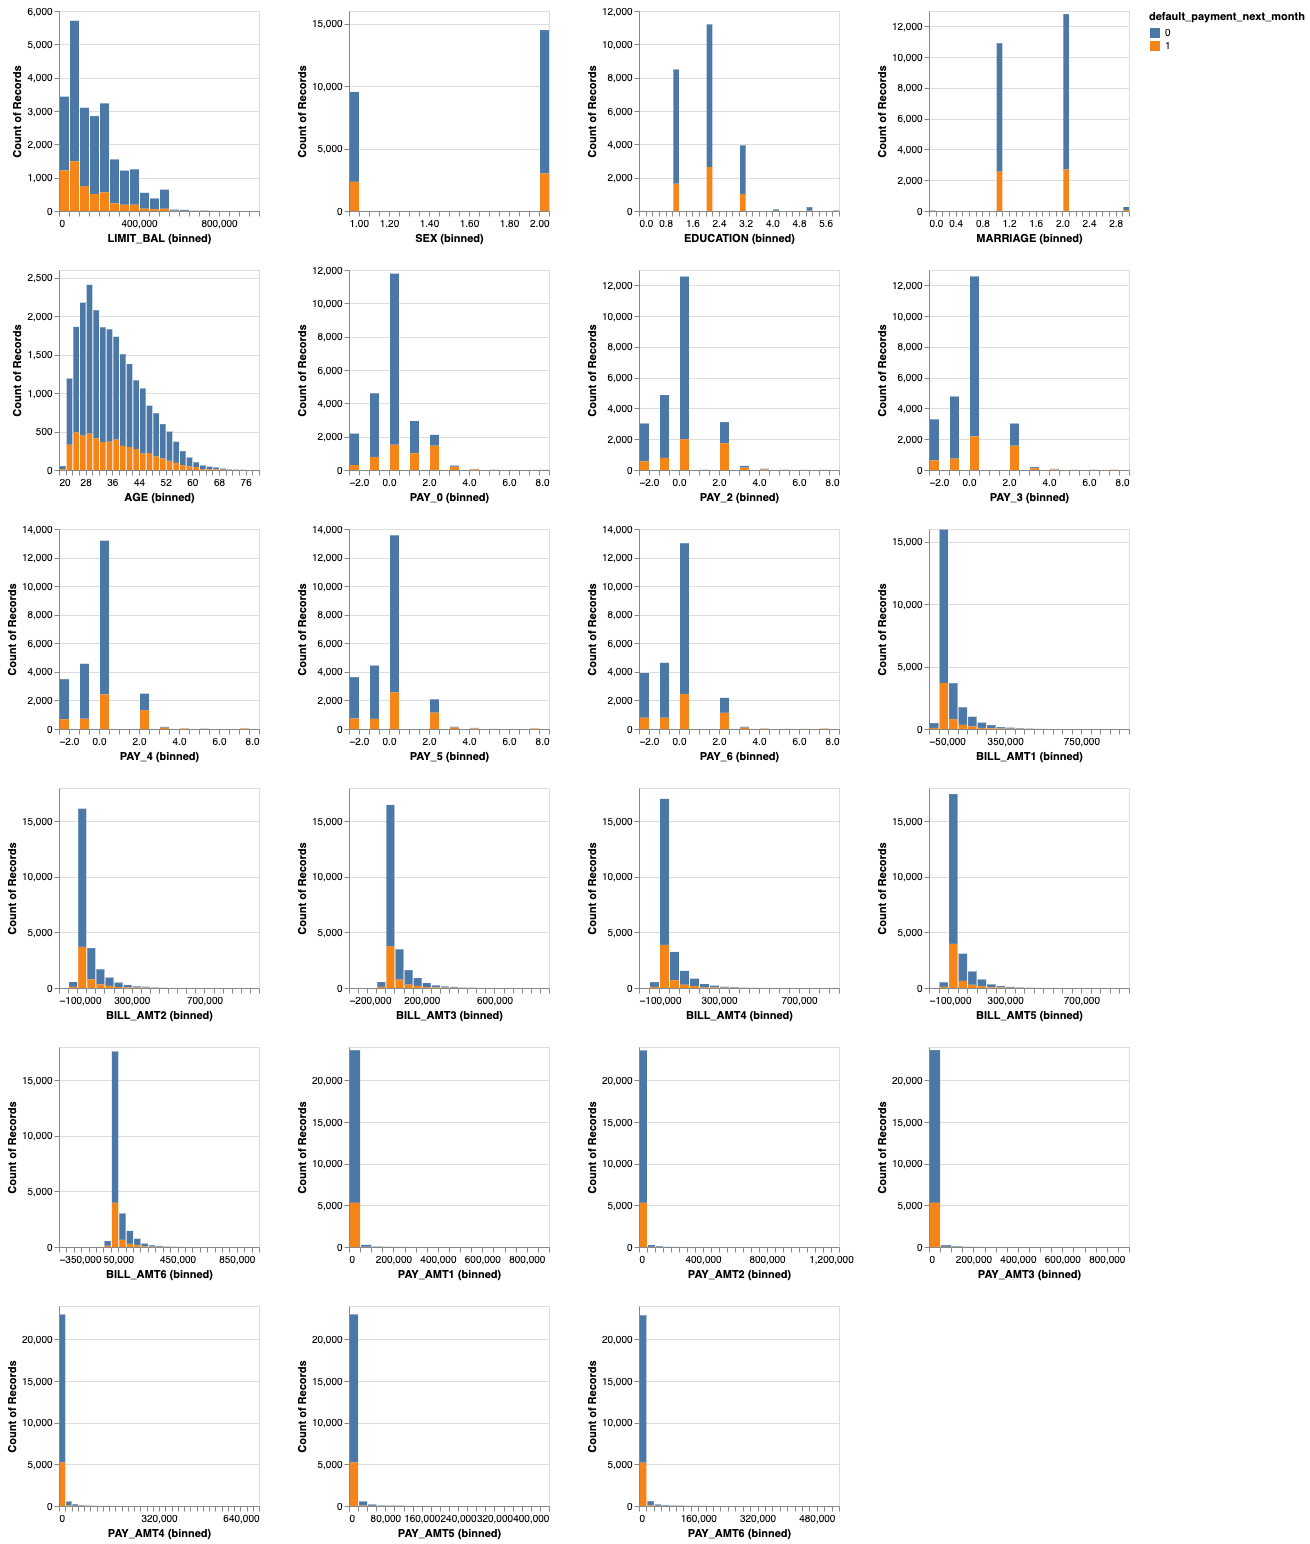

In [8]:
train_df["default_payment_next_month"] = train_df["default_payment_next_month"].apply(str)

alt.Chart(train_df).mark_bar().encode(
     alt.X(alt.repeat(), type='quantitative', bin=alt.Bin(maxbins=40), scale= alt.Scale(zero= False)),
     y='count()',
     color = "default_payment_next_month"
).properties(
    width=200,
    height=200
).repeat(
    train_df.columns.to_list()[:-1],
    columns =4
)

The next visualization is more to explore how clients spend and pay their monthly credit, we are interested to see if there is any sort of correlation or pattern between those features. In order to avoid overplotting due to high amount of data points in the train data, instead of plotting a scatter plot, we have instead plotted a 2D histogram. On the y-axis you will see binned bill months from months April(1) to September(6). Similarly, on the x-axis you will observe binned payment amounts for each month. A darker color for a bin represents higher counts. 

From the plots below, one thing that is interesting to note is that the highest amount of counts are for clients that have spent and paid between 0 - 50,000 in credit for each month. Consequently we also see a kind of negative correlation between pay amounts and bill amounts for each month. This means that people who are spending higher amounts of money are very unlikely to pay it back on time. 

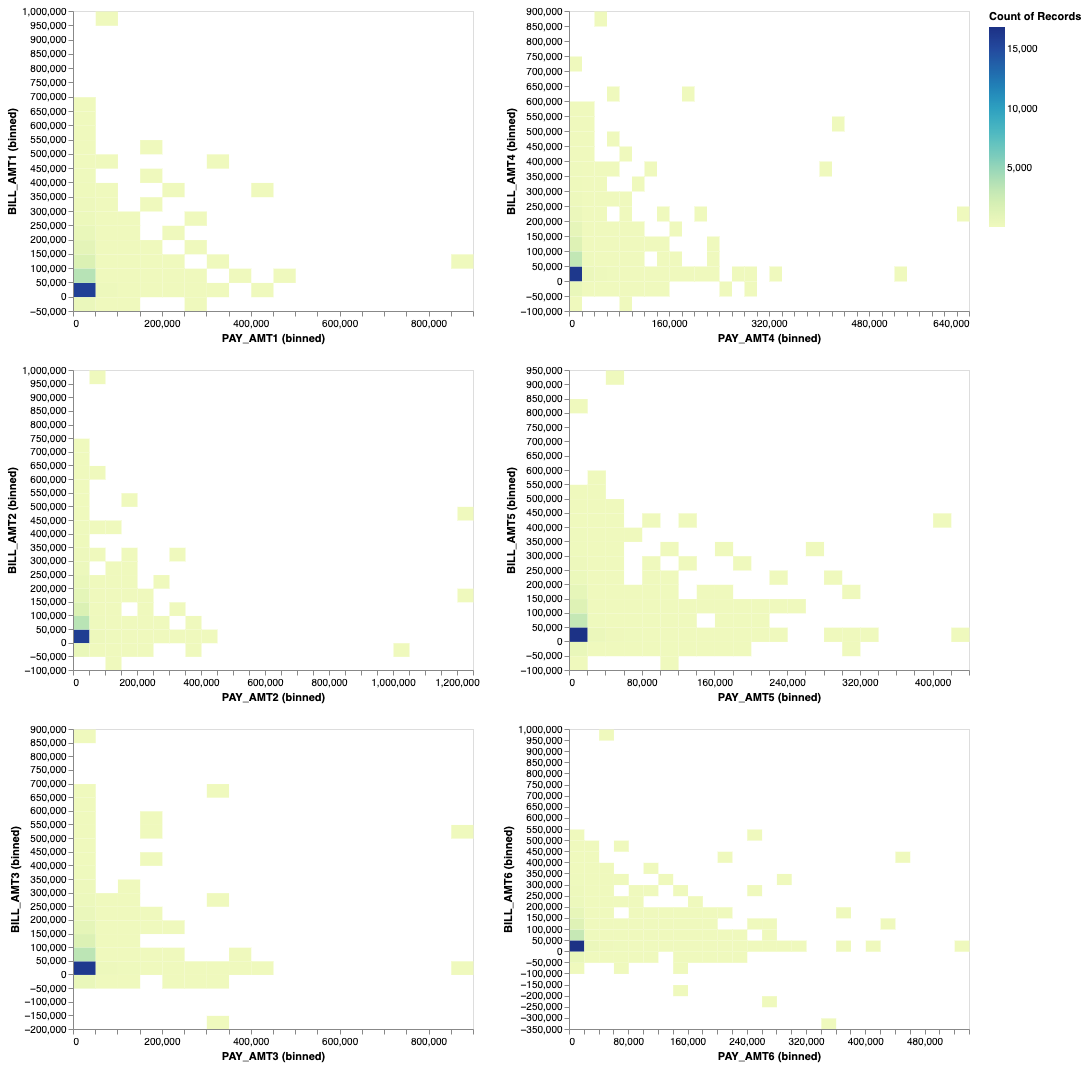

In [13]:
pay = ['PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5', 'PAY_AMT6']
bill = ['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5', 'BILL_AMT6']
graph = []

for i in range(len(bill)):
    month = alt.Chart(train_df).mark_rect().encode(
        alt.X(pay[i], bin=alt.Bin(maxbins=40)),
        alt.Y(bill[i], bin=alt.Bin(maxbins=40)),
        alt.Color('count()'))
    graph.append(month)

(graph[0] & graph[1] & graph[2]) | (graph[3] & graph[4] & graph[5])